# Projektarbeit im Modul "Machine Learning for Business"

Gruppenmitglieder:
   - Santo Lo Tauro (7037254)
   - Timur Werner (7037681)
   - Marvin Jongen (7038295)
   

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import itertools
import json
import spacy
from nltk.tokenize import word_tokenize
import nltk
import statsmodels.api as sm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.manifold import TSNE
from collections import Counter    # Look at the most common item in a list

import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import lime
import lime.lime_tabular
from lime.lime_text import LimeTextExplainer
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn import svm
from sklearn import ensemble
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# initialize js for SHAP
shap.initjs()

In [3]:
dataframes = []
for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        p = os.path.join(dirname, filename)
        if 'csv' in p:
            print('Read'+p)
            dataframes.append(pd.read_csv(p))

Read/kaggle/input/skytrax-reviews-dataset-august-2nd-2015/repository/quankiquanki-skytrax-reviews-dataset-bd4997c/data/airport.csv
Read/kaggle/input/skytrax-reviews-dataset-august-2nd-2015/repository/quankiquanki-skytrax-reviews-dataset-bd4997c/data/seat.csv
Read/kaggle/input/skytrax-reviews-dataset-august-2nd-2015/repository/quankiquanki-skytrax-reviews-dataset-bd4997c/data/lounge.csv
Read/kaggle/input/skytrax-reviews-dataset-august-2nd-2015/repository/quankiquanki-skytrax-reviews-dataset-bd4997c/data/airline.csv


In [4]:
try:
    airline = pd.read_csv("airline.csv")
except FileNotFoundError:
    # Bei Windows dataframes[0]
    airline = dataframes[3]

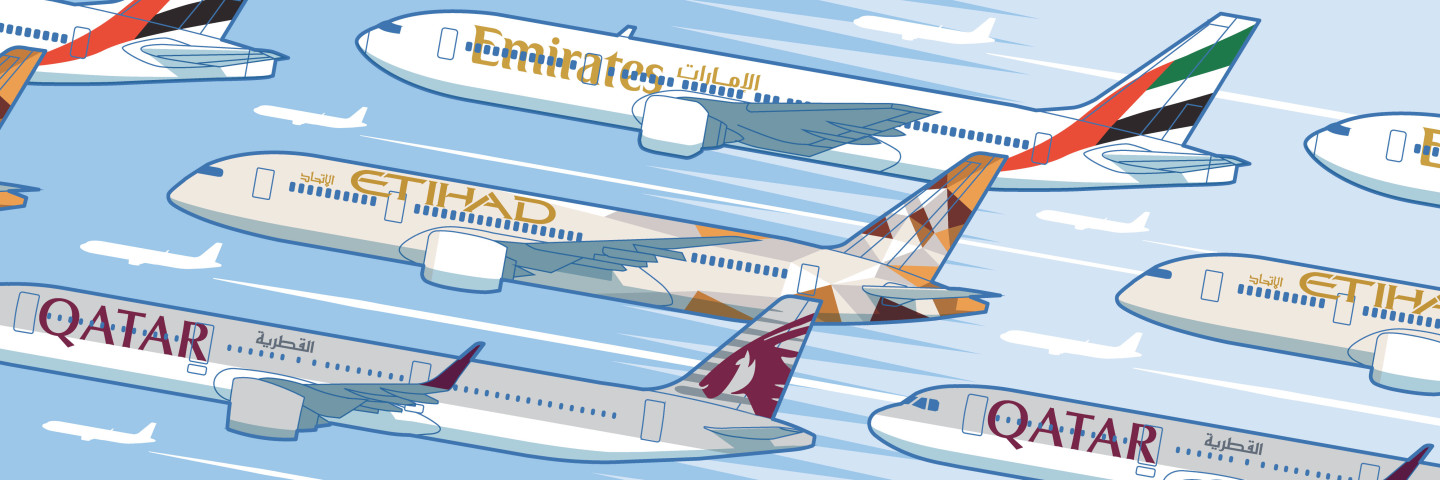

Quelle: Financial Times

# Was ist Passagieren wichtig?
Das übergeordnete Ziel dieser Arbeit besteht darin, Erkenntnisse und Einblicke aus dem Datensatz zu gewinnen. Aus diesem Grund wird im ersten und zweiten Teil auf komplexe *Black Box* Modelle und Algorithmen wie z. B. SVM, Ensemble-Methoden oder Neuronale Netze verzichtet. Im dritten Teil wird dann versucht diese *Black Box* Modelle interpretierbar zu machen und Zusammenhänge zu erkennen. Es wird unter Anderem untersucht, welche Faktoren eine gute Bewertung beeinflussen, was gute Airlines von schelchten Airlines unterscheidet und ob Passagiere bei Low-Cost Airlines andere Faktoren als wichtig empfinden, als bei klassischen Airlines.

Der Datensatz, der hierfür verwendet wird besteht aus Bewertungen der Website "Skytrax" (https://www.airlinequality.com/). Der Datensatz ist unter folgendem Link verfügbar (https://github.com/quankiquanki/skytrax-reviews-dataset). 

Dieses Notebook wurde mithilfe von Kaggle erstellt. Es empfiehlt sich daher dieses Notebook als Kernel zu diesem folgendem Datensatz zu importieren: https://www.kaggle.com/austinpeck/skytrax-reviews-dataset-august-2nd-2015.

## Inhaltsverzeichnis
### 1. Analyse mit EDA
    1.1 Preprocessing vor EDA
    1.2 EDA mit strukturierten Daten
    1.3 EDA mit unstrukturierten Daten
    1.4 Topic Modeling
### 2. Analyse mit Regression
    2.1 Preprocessing nach EDA
    2.2 Ridge Regression
    2.3 Logistic Regression
### 3. Lokale und Globale Interpretation Nicht-Linearer Modelle
    3.1 LIME
    3.2 SHAP
    3.3 Interpretation unstrukturierter Daten
    3.4 Interpretation strukturierter Daten
### 4. Zusammenfassung und Fazit



In den folgenden Kaptieln werden die Einflussfaktoren untersucht, die sich auf die Gesamtbewertung von Airlines auswirken. Hierfür werden Regressionen mit den folgenden unabhängigen Variablen durchgeführt:

    - seat_comfort_rating                     Sitzkomfort
    - cabin_staff_rating                      Kabinenpersonal
    - food_beverages_rating                   Verpflegung an Board
    - inflight_entertainment_rating           Entertainment System
    - value_money_rating                      Preis/Leistungs Verhältnis
    - cabin_flown                             Beförderungsklasse

Als unabhängige Variable(n) wird die Gesamtbewertung benutzt:

    - overall_rating
    - recommended

Es gibt zwei verschiedene Variablen, die als Zielvariablen verwendet werden können. Wenn das Problem als Klassifikation angegangen werden soll, wird *recommended* verwendet und als Regression wird *overall_rating* verwendet.

Zunächst können wir uns eine Übersicht über den Datensatz verschaffen.

In [5]:
airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41396 entries, 0 to 41395
Data columns (total 20 columns):
airline_name                     41396 non-null object
link                             41396 non-null object
title                            41396 non-null object
author                           41396 non-null object
author_country                   39805 non-null object
date                             41396 non-null object
content                          41396 non-null object
aircraft                         1278 non-null object
type_traveller                   2378 non-null object
cabin_flown                      38520 non-null object
route                            2341 non-null object
overall_rating                   36861 non-null float64
seat_comfort_rating              33706 non-null float64
cabin_staff_rating               33708 non-null float64
food_beverages_rating            33264 non-null float64
inflight_entertainment_rating    31114 non-null float64
ground_se

      - airline_name: Name der Airline
      - link: URL zu der Review auf Skytrax
      - title: Titel der Review
      - author: Autor der Review
      - author_country: Herkunftsland des Autors
      - date: Datum der Review
      - content: Bewertungstext
      - aircraft: Flugzeugmuster
      - type_traveller: Art der Reise (z.B. Urlaub, Geschäftsreise,...)
      - cabin_flown: Beförderungsklasse (z.B. Economy, Business,...)
      - route: Flugstrecke
      - overall_rating: Gesamtbewertung von 1 bis 10
      - seat_comfort_rating: Bewertung des Sitzkomforts von 1 bis 5
      - cabin_staff_rating: Bewertung des Kabinenpersonals von 1 bis 5
      - food_beverages_rating: Bewertung der Speisen und Getränke im Flugzeug von 1 bis 5
      - inflight_entertainment_rating: Bewertung des In-Flight Entertainment Systems
      - ground_service_rating: Bewertung der Dienstleistungen am Boden (z.B. Check-In) von 1 bis 5
      - wifi_connectivity_rating: Bewertung der WiFi-Verbindung im Flugzeug von 1 bis 5
      - value_money_rating: Bewertung des Preis-Leistungs-Verhältnisses von 1 bis 5
      - recommended: Angabe zur Weiterempfehlung der Airline (0 oder 1)

# 1. Analyse mit EDA
### Preprocessing vor EDA

Ein für die Analyse wichtiger Einflussfaktor ist die Beförderungsklasse. Diese ist momentan noch als String (bzw. Object) im Datensatz vorhanden. Damit diese in der Visualisierung genutzt werden kann, muss diese zunächst in einen numerischen Wert umgewandelt werden. Des Weiteren sind die Klassen ordinal skaliert d. h. sie können in eine Reihenfolge gebracht werden (First Class > Business Class > Premium Economy > Economy).

In [6]:
airline['cabin_flown'] = airline.cabin_flown.map({'Economy': 0, 'Premium Economy': 1/3, 'Business Class': 2/3, 'First Class': 1})

Ein weiterer Preprocessing Schritt, zu dem wir uns entschieden haben, ist alle Airlines, die weniger als 100 Bewertungen haben aus dem Datensatz zu entfernen.

In [7]:
# Namen der Airlines bestimmen, die mehr als 100 Bewertungen haben
obsPerAirline = airline["airline_name"].value_counts()
obsPerAirline.where(obsPerAirline >= 100, inplace=True)
obsPerAirline.dropna(inplace=True)
airlinesToKeep = obsPerAirline.keys().tolist()

# Datensatz anpassen
airline = airline[airline["airline_name"].isin(airlinesToKeep)]

Zunächst bereiten wir den Text vor, indem wir alle Token entfernen, die nicht alphanumerische sind

In [8]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
for index, row in airline.iterrows():
    text = nlp(row["content"])
    tokens_to_keep = []
    for token in text:
        if token.is_alpha:
            tokens_to_keep.append(token.lemma_)
    airline.at[index,"text_prep"] = " ".join(tokens_to_keep)

Im folgenden werden die Airlines mit den durchschnittlich besten und schlechtesten Bewertungen abgespeichert. Dies wird gemacht, um im Kapitel 1.3 einen Topic Modeling Algorithmus auf die (durchschnittlich) schlechter und die besser bewerteten Airlines anwenden zu können.

In [9]:
grouped = airline.groupby(['airline_name']).mean()
grouped = grouped.reset_index()
grouped_worst = grouped.sort_values('overall_rating', ascending=True)
grouped_best =  grouped.sort_values('overall_rating', ascending=False)
counter = (len(grouped_worst)//4)
bad_airlines = airline.loc[airline['airline_name'].isin(grouped_worst['airline_name'][:counter])]
good_airlines = airline.loc[airline['airline_name'].isin(grouped_best['airline_name'][:counter])]
len(bad_airlines),len(good_airlines)

(10168, 8601)

### EDA mit strukturierten Daten
Zunächst einmal betrachten wir die Verteilungen der unabhängigen Variablen (sowohl *recommended* als auch *overall_rating*).

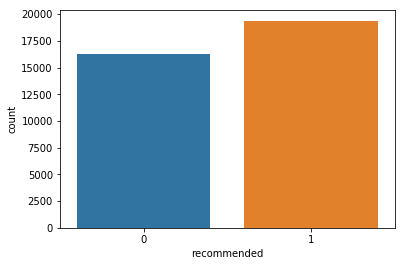

In [10]:
sns.countplot(airline.recommended)
plt.show()

Es fällt auf, dass der Großteil (etwa 3/5) der Reviewer die Airline weiterempfehlen würden. Darüber hinaus sind die Daten hinreichend gleichverteilt, sodass keine Anpassung in Form von Over- oder Undersampling notwendig ist.

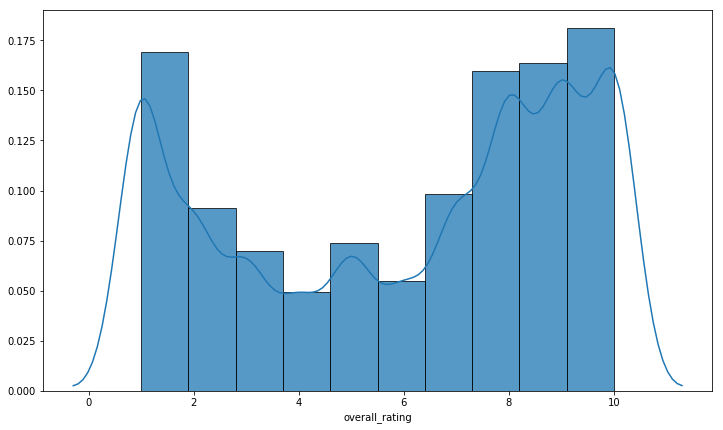

In [11]:
plt.figure(figsize=(12,7))
sns.distplot(airline.overall_rating.dropna(), kde=True, bins = 10, hist_kws={"rwidth":1,'edgecolor':'black', 'alpha':.75})

Selbiges zeigt sich, wenn man sich die Verteilung der Ratings anguckt. Zum Mittelfeld hin, außer im Zentrum, nimmt die Häufigkeit der Ratings ab. Das schlechteste und beste Rating sind entsprechend umso häufiger verteten. Ohne den Ausreißer im Zentrum gäbe es eine (fast) perfekte J-Kurve (Hu et al. 2005). Alles in allem spiegelt sich auch hier die positivere Tendenz / Stimmung der Reviewer aus dem vorherigen Plot wider, da es mehr positive als negative Ratings gibt.

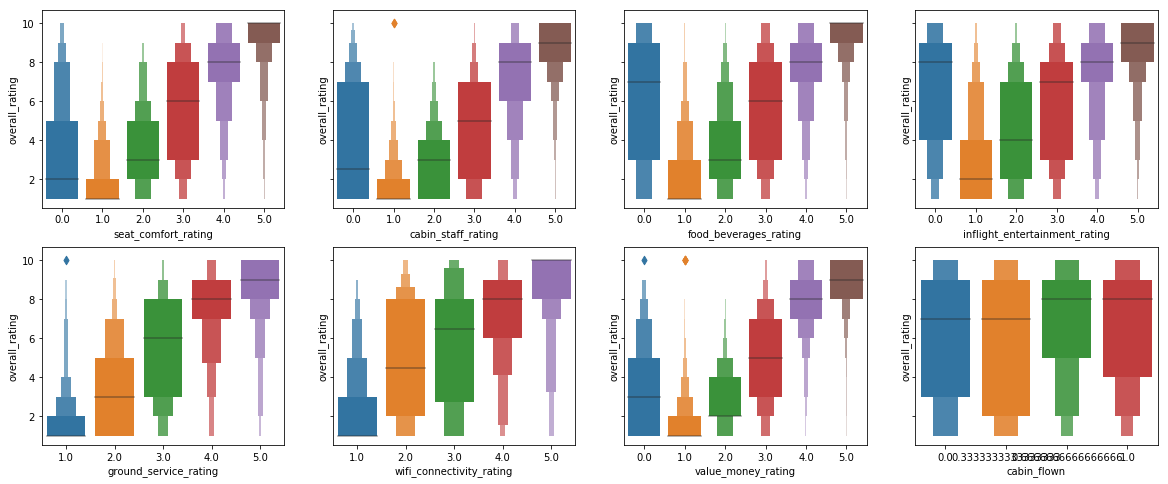

In [12]:
variables = ['seat_comfort_rating','cabin_staff_rating','food_beverages_rating','inflight_entertainment_rating','ground_service_rating','wifi_connectivity_rating','value_money_rating','cabin_flown']
f, axes = plt.subplots(2, 4,figsize=(20,8),sharey=True)
for i in range(4):
    for j in range(2):
        if i+j*4 < 8:
            sns.catplot(x=variables[i+j*4], y="overall_rating", kind="boxen", data=airline, ax=axes[j,i]);
for i in range(2,12):
    plt.close(i)

Die Plots zeigen, dass das *overall_rating* zunimmt, wenn auch die anderen Kategorien zunehmen. Dies war zu erwarten, da es sich bei allen Kategorien ebenfalls um ein Rating handelt, jedoch in einer spezielleren Form. Eine besonders starke Abhängigkeit zeigt sich beim Preis- Leistungsverhältnis.
Außerdem gibt es die Möglichkeit die Bewertung zu einer der Kriterien nicht zu tätigen. Dadurch sind einige Kriterien mit 0 bewertet worden aber gleichzeitig wurde ein mittelmäßiges *overall_rating* vergeben.

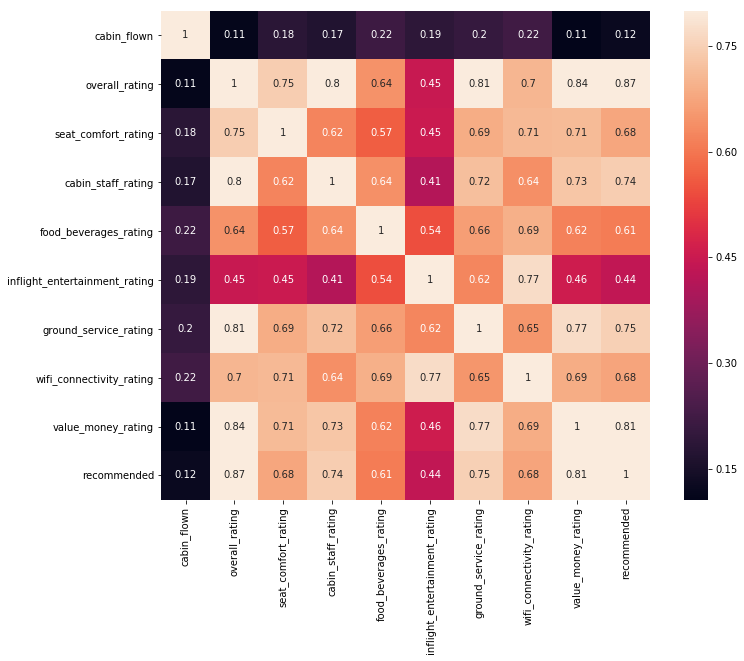

In [13]:
corrmat = airline.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat,vmax=0.8,square=True, annot=True)

Um einen Überblick über die Korrelationen zwischen den Parameter zu verschaffen, erstellen wir im nächsten Schritt eine Korrelationsmatrix mithilfe einer Heatmap. Dieser Plot hilft dabei schnell Variablen zu identifizieren, die miteinander korreliert sind (bzw. inwiefern sie es sind). So decken sich die Ergebnisse mit dem Plot darüber z. B. insofern, als dass die Klasse (*cabin_flown*) nur leicht mit dem Rating korreliert ist. D. h. obwohl sich die Passagiere für eine teurere Klasse entschieden haben, hat sich dies nur unwesentlich auf ihr Gesamturteil ausgewirkt. Ergänzend zu den Ergebnissen davor, fällt auf, dass es eine starke Korrelation zwischen dem *overall_rating* und dem *recommended* Parameter gibt. Dies war zu erwarten ist eine Voraussetzung für das weitere Vorgehen in dieser Arbeit.

### **EDA** mit unstrukturierten Daten

Mit dem Package WordCloud wird selbige erstellt. Dazu muss zunächst der vollständige Text in einer Variable abgespeichert werden. Anschließend kann der WordCloud entnommen werden, welche Wörter von den Passagieren besonders oft verwendet werden. Dies gibt bereits einen ersten Hinweis darauf, was Kunden von Airlines beim Schreiben eines Reviews *bewegt*.

In [14]:
unigrams = " ".join(review for review in airline.content)
bigrams = nltk.bigrams(unigrams)

In [15]:
def generate_wordcloud(grams,plot_title,num_words):
    grams = grams.upper()
    wordcloud = WordCloud(width=1800, height=900, max_font_size=200, max_words=num_words,
                          random_state=42,contour_color='steelblue',colormap=plt.cm.twilight_shifted,
                          background_color="white").generate(grams)
    plt.figure(figsize=(20,10))
    plt.title(plot_title, fontsize=20, fontweight='bold', y=-0.2)
    plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
    plt.axis("off")

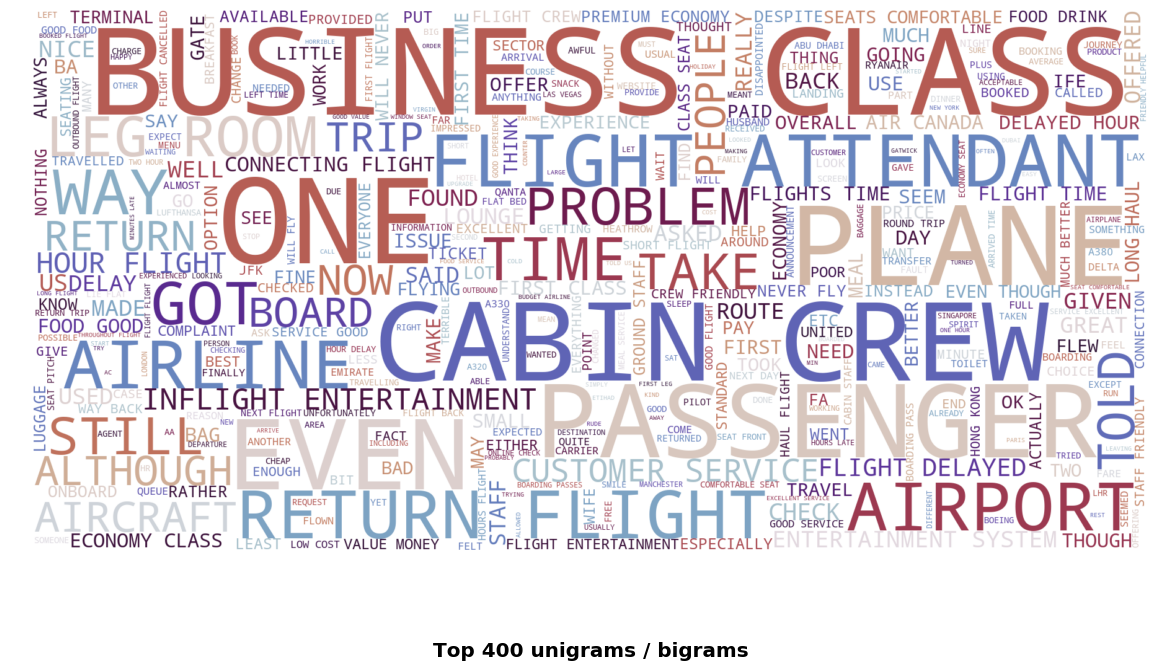

In [16]:
generate_wordcloud(unigrams,"Top 400 unigrams / bigrams",400)

Um einen ersten Überblick zu den unstrukturierten Daten zu erhalten eignet sich insbesondere eine Wordcloud, da diese zeigt, welche Wörter und Wortkombinationen von den Reviewern besonders häufig verwendet werden.
Es ist zu sehen, dass viele Reviews über den Ausdruck "Business Class" enthalten. Daraus könnte man schließen, dass viele Bewertungen über die entsprechende Beförderungsklasse handeln. Auch die Ausdrücke "Cabin Crew" und "Flight Attendant" erscheinen häufig, was bedeuten könnte, dass der Service an Bord eine wichtige Rolle spielt. Eine untergeordnete Rolle scheint zum Beispiel das Preis-Leistungs-Verhältnis zu spielen.

### Topic Modeling
Was wird über Airlines geschrieben, die durchschnittlich schlechter bzw. besser bewertet worden sind? Um dieser Frage nachzugehen, wurden weiter oben zwei Dataframes, mit eben jenen Bewertungen, erstellt. Es gibt verschiedene Topic Modeling Algorithmen, mit denen die Themen identifiziert werden können dazu kann z. B. Non-negative matrix factorization, Latent Semantic Indexing oder Latent Dirichlet Allocation genutzt werden. Wir haben uns für letzteren entschieden.

LDA ist eine unüberwachte Methode aus dem Bereich der Themenmodelle /-modellierung,sowie der natürlichen Sprachverarbeitung durch Maschinen. Themenmodelle sind hierbei eine Form von Wahrscheinlichkeitsmodellen. Diese dienen dem Zweck, effektiv abstrakte  Themen, die in einem großen Korpus von Dokumenten auftreten,  zu  identifizieren. Als  Dokumente  gelten hier die  Online-Reviews. Es wird angenommen, dass die Wörter in jeder Bewertung unabhängig voneinander aus dem *Wortschatz*  eines  Reviewers gezogen  werden.  Dies  passiert,  indem sie ihre Meinung zu einem Thema formulieren. Die Themen haben dabei alle eine eigene Wortverteilung und sind bewertungsübergreifend verteilt. Sie können somit in mehreren Bewertungen enthalten sein, wobei sie sich nicht ohne Aufwand erkennen lassen, da sie latent sind. Umgekehrt kann auch jede Bewertung einen eigenen Mix aus Themen enthalten, wodurch eine Wort-Themen-Verteilung entsteht. Da die Wörter die latenten Dimensionen repräsentieren, kann folglich durch die Wörter  auf  Themen  geschlossen  werden.  Eine  Dimension  ist  dabei  definiert  als  ein  latentes Konstrukt, das aus Wörtern besteht und (vom jeweiligen Betrachter) als Thema interpretiert wird. Es wird also zusätzlich angenommen, dass Wörter den Dimensionen zugrunde  liegen  und  diese  gemeinsam  in  den  Bewertungen  auftreten.  Die  Dimensionenen sind in Abhängigkeit von ihrer Wichtigkeit über die Bewertungen verteilt. Die Aufgabe von LDA besteht darin, die Verteilung der latenten Dimensionen sowie die Dimensionen selbst aufzudecken. (Blei et al., 2003)

In [17]:
def topic_modeling(docs, no_topics):
    no_features = 2000
    # LDA can only use raw term counts for LDA because it is a probabilistic graphical model
    tf_vectorizer = CountVectorizer(strip_accents='unicode',max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
    tf = tf_vectorizer.fit_transform(docs)
    tf_feature_names = tf_vectorizer.get_feature_names()
    lda = LatentDirichletAllocation(n_components=no_topics, max_iter=10, learning_method='batch', learning_offset=50.,random_state=42)
    lda.fit(tf)
    return lda, tf, tf_vectorizer, tf_feature_names

In [18]:
def display_topics(model, feature_names, no_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

Zunächst betrachten wir die Bewertungen der (laut den Ratings) überdurchschnittlich guten Airlines:

In [19]:
lda_p, tf_p, tf_vectorizer_p, tf_feature_names_p = topic_modeling(good_airlines.content, 6)
pyLDAvis.sklearn.prepare(lda_p, tf_p, tf_vectorizer_p)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.171443 -0.007898       1        1  21.041799
5      0.095016  0.023729       2        1  20.234211
2      0.012662 -0.109954       3        1  15.821920
3     -0.188099 -0.056072       4        1  15.146278
1     -0.116158  0.097886       5        1  14.189967
4      0.025137  0.052310       6        1  13.565826, topic_info=     Category          Freq         Term         Total  loglift  logprob
415   Default   3307.000000        class   3307.000000  30.0000  30.0000
334   Default   2739.000000     business   2739.000000  29.0000  29.0000
760   Default  12191.000000       flight  12191.000000  28.0000  28.0000
286   Default   1148.000000          bkk   1148.000000  27.0000  27.0000
1172  Default   1043.000000      minutes   1043.000000  26.0000  26.0000
...       ...           ...          ...           ...      ...      ...
416    Topic6    298.444632        clean   1104.274318   0.6893  -5.2031
438    Topic6    352.754101  comfortable   2242.921571   0.1479  -5.0359
684    Topic6    345.344616    excellent   2233.272259   0.1309  -5.0571
131    Topic6    292.843607     airlines   1490.141649   0.3706  -5.2220
640    Topic6    299.712715      economy   2287.104464  -0.0346  -5.1989

[435 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
12        1  0.024623      15
12        2  0.093566      15
12        3  0.123113      15
12        4  0.618027      15
12        5  0.120651      15
...     ...       ...     ...
1999      1  0.025232  zurich
1999      2  0.022078  zurich
1999      3  0.933581  zurich
1999      4  0.003154  zurich
1999      5  0.012616  zurich

[1153 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 3, 4, 2, 5])

In [20]:
display_topics(lda_p, tf_feature_names_p)

Topic 0:
good flight food service excellent comfortable cabin class seat seats
Topic 1:
flight staff seats return flights time airline airport plane london
Topic 2:
flight service meal crew served food good time drinks cabin
Topic 3:
flight check time boarding minutes passengers airport plane gate luggage
Topic 4:
flight good flights service time crew friendly seats food cabin
Topic 5:
class business service food seats flight seat good bkk economy


#### Interpretation der Ergebnisse:
In Topic 0 ist zu erkennen, das positive Bewertungen oft von dem Service im Flugzeug, wie zum Beispiel dem Essen oder dem Sitzkomfort beeinflusst wird. Darauf deuten wor allem die Wörter "service", "comfortable" und "seat"/"seats" hin. Auch die Topics 1, 2, 4 und 5 scheinen über den Service zu handeln. Einzig Topic 3 handelt offenbar über die Pünktlichkeit und Zuverlässigkeit der Airline. Dieses Resultat zeigt, dass überdurchschittlich gute Airlines meist mit gutem Service und Pünktlichkeit und Zuverlässigkeit bei den Gästen punkten.

Nun betrachten wir die Bewertungen der Airlines, die unterdurchschnittlich gut abgeschnitten haben:

In [21]:
lda_n, tf_n, tf_vectorizer_n, tf_feature_names_n = topic_modeling(bad_airlines.content, 5)
pyLDAvis.sklearn.prepare(lda_n, tf_n, tf_vectorizer_n)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.132712 -0.089941       1        1  26.724432
1     -0.171786 -0.068048       2        1  26.028379
2     -0.101245  0.078066       3        1  19.638151
4      0.049969 -0.023013       4        1  16.579724
0      0.090350  0.102936       5        1  11.029313, topic_info=     Category         Freq        Term        Total  loglift  logprob
127   Default  3226.000000         air  3226.000000  30.0000  30.0000
342   Default  1636.000000      canada  1636.000000  29.0000  29.0000
1538  Default  1288.000000       rouge  1288.000000  28.0000  28.0000
1587  Default  4424.000000        seat  4424.000000  27.0000  27.0000
1592  Default  5157.000000       seats  5157.000000  26.0000  26.0000
...       ...          ...         ...          ...      ...      ...
695    Topic5   314.425755  experience  1981.769102   0.3636  -5.2490
1806   Topic5   407.783400        time  5655.182702  -0.4250  -4.9890
1847   Topic5   284.903700        trip  2051.179506   0.2306  -5.3476
1701   Topic5   289.884778       staff  3688.318584  -0.3388  -5.3302
1519   Topic5   280.072765      return  2892.362574  -0.1302  -5.3647

[383 rows x 6 columns], token_table=      Topic      Freq Term
term                      
3         1  0.075075  100
3         2  0.035905  100
3         3  0.842142  100
3         4  0.003264  100
3         5  0.045698  100
...     ...       ...  ...
1996      5  0.991988  yyc
1997      1  0.115153  yyz
1997      2  0.002617  yyz
1997      4  0.002617  yyz
1997      5  0.879348  yyz

[943 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 5, 1])

In [22]:
display_topics(lda_n, tf_feature_names_n)

Topic 0:
air flight canada rouge toronto seats ac service seat entertainment
Topic 1:
flight hours delayed airport plane time hour told gate minutes
Topic 2:
flight airline time spirit pay fly bag airlines check carry
Topic 3:
flight good food service class time crew business flights seats
Topic 4:
flight seat seats plane crew food staff cabin did passengers


#### Interpretation der Ergebnisse
In Topic 1 ist zu erkennen, dass ein wiederkehrendes Thema in negativen Bewertungen Verspätungen im Flugbetrieb sind. So weisen die Wörter "delayed", "time", "houer, "minutes" auf Verspätungen des Fluges hin auch "gate" könnte ein Hinweis darauf sein, dass Kunden am Gate warten mussten und der Flug verspätet war. Die Verpflegung hat, so wie bei den positiven Bewertunge,n auch ein Einflussfaktor, hier allerdings einen negativen. Es ist also zu erkennen, dass dieser Faktor sowohl einen positiven als auch einen negativen Einfluss haben kann. Interessant ist außerdem, dass in Topic 0 und Topic 2 explizit Namen von Airlines genannt werden (Air Canada Rouge, Spirit). Air Canada Rouge ist die am schlechtesten bewertete Airline in dem Datensatz, was diese Topic erklären könnte. Insgesamt zeigen die Ergebnisse, dass unterdurchschnittliche Airlines oft Verspätungen haben und keinen guten Service anbieten.

# 2. Analyse mit Regression

## Preprocessing nach EDA
Im folgenden werden die Daten in eine Form gebracht, die sich für eine Regression eignet. Regressionen bieten im Gegensatz zu komplexeren Modellen den Vorteil, dass sie direkt interpretiert werden können. Es ist somit möglich das Modell global (also nicht auf der Ebene einzelner Vorhersagen) zu interpretieren und somit die *Gesamtstruktur* des Modells zu verstehen.

Es ist zu erkennen, dass die Zeilen "aircraft", "route", "ground_service_rating" und "wifi_connectivity_rating" eine vergleichsweise niedrige Anzahl an Observationen haben. Wir haben uns daher entschieden diese nicht zu betrachten. 

Als nächstes müssen wir nun die oben genannten Spalten und alle Zeilen, die NULL Werte enthalten aus unserem Datensatz entfernen

In [23]:
columns_drop = ["aircraft","wifi_connectivity_rating","ground_service_rating","route","type_traveller","link"]
airline.drop(columns_drop, axis=1, inplace=True)
airline.dropna(inplace=True)

Um der Ausgangsfrage nachzugehen erstellen wir einen Vektor, der die Zielvariable (overall_rating) enthält und eine Matrix mit allen für die Regression wichtigen Parametern.

In [24]:
y = airline["overall_rating"]
dropForRegression = ["airline_name","title","author","author_country","date","content","text_prep", "recommended", "overall_rating"]
X = airline.drop(dropForRegression, axis=1)

Im nächsten Schritt wird das Regressionsmodell erstellt. Um Multikollinearität zu vermeiden haben wir uns entscheiden eine Ridge-Regression zu nutzen (L1_wt=0.000001. Normalerweise muss dieser Wert auf 0 gesetzt werden, um eine Ridge-Regression zu erhalten, allerdings kann dann nicht mehr die summary-Funktion genutzt werden. Dies ist ein bekanntes Problem und ein offener Issue im statsmodels Package, siehe: https://github.com/statsmodels/statsmodels/issues/3670).

Die Ridge-Regression unterscheidet sich folgendermaßen von einer OLS Regression: In einer OLS Regression werden die Koeffizienten mit folgender Formel bestimmt (Singh n.d.):
\begin{align}
B &= (X'X)^{-1}X'Y 
\end{align}

Bei der Ridge-Regression wird nun zu den diagonalen Elementen der Korrelationsmatrix ($X'X$) ein kleine Wert $k$ hinzugefügt (Singh n.d.):
\begin{align}
\widetilde{B} &= (X'X+kI)^{-1}X'Y 
\end{align}
Der Bias dieses Schätzers ist dabei (Singh n.d.):
\begin{align}
E(\widetilde{B}-B) &= [(X'X+kI)^{-1}X'X-I]B
\end{align}
Die Kovarianzmatrix ist folgendermaßen definiert (Singh n.d.):
\begin{align}
V(\widetilde{B}) &= (X'X+kI)^{-1}X'X(X'X+kI)^{-1}
\end{align}

Es kann gezeigt werden, dass es einen Wert für $k$ gibt für den der Mean Squared Error geringer ist, als bei der OLS Regression. Allerdings gibt es aktuell keine Methode um eine endeutig optimale Lösung zu ermittlen, was ein Nachteil dieser Methode sein kann (Singh n.d.).

In [25]:
model = sm.OLS(y, X).fit_regularized(L1_wt=0.000001, refit=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         overall_rating   R-squared (uncentered):                   0.952
Model:                            OLS   Adj. R-squared (uncentered):              0.952
Method:                 Least Squares   F-statistic:                          8.446e+04
Date:                Tue, 10 Sep 2019   Prob (F-statistic):                        0.00
Time:                        09:04:02   Log-Likelihood:                         -46353.
No. Observations:               25429   AIC:                                  9.272e+04
Df Residuals:                   25423   BIC:                                  9.277e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
cabin_flown                      -0.1639      0.032     -5.106      0.000      -0.227      -0.101
seat_comfort_rating               0.2888      0.010     29.013      0.000       0.269       0.308
cabin_staff_rating                0.5153      0.010     53.868      0.000       0.497       0.534
food_beverages_rating             0.1520      0.009     16.845      0.000       0.134       0.170
inflight_entertainment_rating     0.0029      0.007      0.445      0.656      -0.010       0.016
value_money_rating                0.8949      0.011     81.745      0.000       0.873       0.916
==============================================================================
Omnibus:                     1090.012   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1603.690
Skew:                          -0.407   Prob(JB):                         0.00
Kurtosis:                       3.923   Cond. No.                         26.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Interpretation der Ergebnisse:

Zunächst ist zu sehen, dass der ausschlaggebende Faktor, dafür dass eine Airline gut bewertet ist das Preis-Leistungsverhältnis ist. So steigt die Gesamtbewertung um circa 0.89 Sterne, wenn das Preis- Leistungsverhältnis um einen Stern steigt. Der zweitwichtigste Faktor ist die Bewertung des Kabinenpersonals gefolgt vom Sitzkomfort. Ein leichter negativer Zusammenhang ist bei der Berförderungsklasse zu erkennen. Wenn hier eine höhere Klasse gewählt wurde, sinkt die Gesamtbewertung um 0.16 Sterne. Dieses Resultat scheint zunächst etwas verwunderlich, da eine höhere Sitzklasse in der Regel einen höheren Komfort bietet und sich daher positiv in Bezug auf die Gesamtwertung auswirken sollte. Höhere Sitzklassen sind in der Regel allerdings auch teurer und da vorher festgestellt wurde, dass das Preis- Leistungsverhältnis der ausschlaggebende Faktor bei der Bewertung einer Airline ist, könnte eine höhere Beförderungsklasse auch mit einer höheren Erwartungshaltung einhergehen.

### Unterschiede zwischen klassischen und low-cost Airlines

Im folgenden wollen wir untersuchen ob unterschiedliche Faktoren die Gesamtbewertung von klassischen und low-cost Airlines beeinflussen.

Hierfür müssen wir zunächst die entsprechenden Airlines indentifizieren und daraufhin die Datensätze entsprechend aufteilen. Die restlichen Schritte bleiben identisch zum ersten Regressionsmodell.

In [26]:
lowCostCarrieres = ["air-canada-rouge","jet-airways", "sunwing-airlines", "thomson-airways", "norwegian", 
                    "thomas-cook-airlines", "air-transat", "jetstar-airways", "air-berlin", "scoot", "wizz-air", 
                    "vueling-airlines", "brussels-airlines", "tigerair", "airasia", "allegiant-air", "monarch-airlines"
                    "frontier-airlines", "aegean-airlines", "flybe", "alaska-airlines", "bangkok-airways", 
                    "kenya-airways", "airasia-x", "fiji-airways", "aerolineas-argentinas"]

classicCarriers = ["british-airways", "united-airlines","emirates","lufthansa","american-airlines", "qantas-airways",
                   "etihad-airways", "cathay-pacific-airways", "qatar-airways","air-canada","malaysia-airlines",
                   "virgin-atlantic-airways", "singapore-airlines", "china-southern-airlines", "air-france",
                   "delta-air-lines", "thai-airways", "garuda-indonesia", "klm-royal-dutch-airlines", 
                   "swiss-international-air-lines", "virgin-australia", "iberia", "aer-lingus", "tap-portugal", 
                   "air-india", "finnair", "korean-air", "air-new-zealand", "alitalia", "vietnam-airlines", 
                   "sas-scandinavian-airlines", "austrian-airlines", "asiana-airlines", "china-eastern-airlines",
                   "us-airways", "eva-air", "srilankan-airlines", "air-china", "lan-airlines", 
                   "aeroflot-russian-airlines", "south-african-airways", "royal-brunei-airlines", 
                   "ana-all-nippon-airways", "philippine-airlines", "china-airlines", "ethiopian-airlines", 
                   "virgin-america", "icelandair", "egyptair", "oman-air", "tam-airlines", "hawaiian-airlines", 
                   "japan-airlines", "royal-jordanian-airlines", "lot-polish-airlines"]

In [27]:
lowCostCarrieresDF = airline[airline["airline_name"].isin(lowCostCarrieres)]
classicCarriersDF = airline[airline["airline_name"].isin(classicCarriers)]

In [28]:
dropForRegression = ["airline_name","title","author","author_country","date","content", "recommended", "text_prep", "overall_rating"]

yLowCost = lowCostCarrieresDF["overall_rating"]
XLowCost = lowCostCarrieresDF.drop(dropForRegression, axis=1)

yClassicCarriers = classicCarriersDF["overall_rating"]
XClassicCarriers = classicCarriersDF.drop(dropForRegression, axis=1)

In [29]:
modelLowCost = sm.OLS(yLowCost, XLowCost).fit_regularized(L1_wt=0.000001, refit=True)
modelLowCost.summary(title = "Regressionsmodell für low-cost Airlines")

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Regressionsmodell für low-cost Airlines                        
=======================================================================================
Dep. Variable:         overall_rating   R-squared (uncentered):                   0.939
Model:                            OLS   Adj. R-squared (uncentered):              0.939
Method:                 Least Squares   F-statistic:                          1.412e+04
Date:                Tue, 10 Sep 2019   Prob (F-statistic):                        0.00
Time:                        09:04:02   Log-Likelihood:                         -10432.
No. Observations:                5519   AIC:                                  2.088e+04
Df Residuals:                    5513   BIC:                                  2.092e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
cabin_flown                      -0.0545      0.111     -0.491      0.623      -0.272       0.163
seat_comfort_rating               0.3323      0.023     14.506      0.000       0.287       0.377
cabin_staff_rating                0.3319      0.021     15.855      0.000       0.291       0.373
food_beverages_rating             0.0742      0.018      4.236      0.000       0.040       0.109
inflight_entertainment_rating    -0.0271      0.015     -1.841      0.066      -0.056       0.002
value_money_rating                1.1107      0.024     46.807      0.000       1.064       1.157
==============================================================================
Omnibus:                      139.944   Durbin-Watson:                   1.736
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              327.889
Skew:                          -0.058   Prob(JB):                     6.31e-72
Kurtosis:                       4.188   Cond. No.                         35.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Interpretation der Ergebnisse
Bei den Low-Cost Airlines ist zu erkennen, dass das Preis-Leistungsverhältnis nochmal wichtiger ist, als in der Gesamtbetrachtung. Die Erklärung hierfür könnte sein, dass Passagiere bei günstigen Ticketpreisen Mängel in anderen Bereichen nicht so stark in die Bewertung miteinfließen. Das ist auch daran zu erkennen, dass der Einflussfaktor der Qualiät des Essens und der Leistung des Kabinenpersonals einen niedrigeren Effekt haben als zuvor. Auffällig ist, dass die Beförderungsklasse hier kaum noch einen negativeren Einfluss hat. Der Grund hierfür ist, dass Low-Cost Airlines meistens nur eine Klasse anbieten, weshalb dieser Faktor keine Rolle mehr spielt.

In [30]:
modelClassicCarriers = sm.OLS(yClassicCarriers, XClassicCarriers).fit_regularized(L1_wt=0.000001, refit=True)
modelClassicCarriers.summary(title = "Regressionsmodell für klassische Airlines")

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Regressionsmodell für klassische Airlines                       
=======================================================================================
Dep. Variable:         overall_rating   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                          6.540e+04
Date:                Tue, 10 Sep 2019   Prob (F-statistic):                        0.00
Time:                        09:04:02   Log-Likelihood:                         -30866.
No. Observations:               17330   AIC:                                  6.174e+04
Df Residuals:                   17324   BIC:                                  6.179e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
cabin_flown                      -0.2022      0.034     -5.878      0.000      -0.270      -0.135
seat_comfort_rating               0.2826      0.012     24.227      0.000       0.260       0.306
cabin_staff_rating                0.5423      0.012     47.092      0.000       0.520       0.565
food_beverages_rating             0.2390      0.012     20.303      0.000       0.216       0.262
inflight_entertainment_rating     0.0152      0.008      1.872      0.061      -0.001       0.031
value_money_rating                0.7901      0.013     59.575      0.000       0.764       0.816
==============================================================================
Omnibus:                     1193.885   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1672.981
Skew:                          -0.595   Prob(JB):                         0.00
Kurtosis:                       3.948   Cond. No.                         25.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Interpretation der Ergebnisse
Bei den klassischen Airlines ist zu erkennen, dass das Preis- Leistungsverhältnis immernoch der wichtigste Faktor ist, allerdings nicht so stark wie zovor. Der Einfluss der anderen Faktoren ist nochmal größer, was dafür spricht, dass auch der Service bei klassischen Airlines einen großen Faktor ausmacht. Auch die Beförderungsklasse hat einen höheren negativen Einfluss als zuvor. Das spricht wieder dafür, dass Kunden hier kritischer bewerten, je höher die Beförderungsklasse ist.


#### Vergleich klassische Airline vs. Low-Cost Airline
Im Vergleich ist klar zu sehen, dass bei klassichen Airlines die zusätzlichen Annehmlichkeiten wie gutes Essen oder ein freundliches Kabinenpersonal wichtig für Passagiere sind. Bei Low-Cost Carrieren spielen diese Faktoren eher eine untergeordnetere Rolle, hier zählt das Preis- Leistungsverhältnis. Des Weiteren spielt die gewählte Klasse bei Low-Cost Airlines keine Rolle, da hier meistens nur eine angeboten wird. Es ist außerdem zu erkennen, dass bei beiden Airline Varianten das In-Flight Entertainment System keine große Rolle spielt. Der Grund hierfür könnte sein, dass Passagiere inzwischen Filme auf eigenen elektronischen Geräten schauen und dieses gar nicht nutzen oder nicht in die Bewertung miteinfließen lassen.

# Wann empfehlen Passagiere eine Airline?

Die nächste Fragestellung, die wir beantworten möchten ist: "Welche Faktoren beeinflussen Passagiere eine Fluglinie zu empfehlen oder nicht zu empfehlen?"

Um diese Frage zu beantworten werden wir mithilfe des Bewertungstextes eine logistische Regression durchführen und daraufhin die Wortkombinationen betrachten, die die Entscheidung des Classifiers am meisten beeinflussen. Damit ein besserer Zusammenhang erkannt werden kann, werden 3-grams zur Analyse des Textes verwendet.

In [31]:
airline.head()

,airline_name,title,author,author_country,date,content,cabin_flown,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,value_money_rating,recommended,text_prep
45,aegean-airlines,Aegean Airlines customer review,Eric Botha,United Kingdom,2015-07-28,"Flight on time, row 1 - Friendly staff and ver...",0.666667,8.0,4.0,5.0,4.0,2.0,4.0,1,flight on time row friendly staff and very att...
60,aegean-airlines,Aegean Airlines customer review,Teresa McCann,United Kingdom,2015-07-07,We flew on flights 4441 and 4440 on 22nd June ...,0.000000,9.0,4.0,5.0,3.0,2.0,5.0,1,-PRON- fly on flight and on June and June both...
66,aegean-airlines,Aegean Airlines customer review,J Adams,Canada,2015-06-04,Multiple trip with AE between SKG-FRA and MUC....,0.000000,10.0,5.0,5.0,4.0,3.0,4.0,1,multiple trip with AE between SKG FRA and MUC ...
67,aegean-airlines,Aegean Airlines customer review,Sean Kyte,United Kingdom,2015-06-04,Flew from Athens to Santorini and back. Flight...,0.000000,8.0,4.0,5.0,4.0,0.0,4.0,1,fly from Athens to Santorini and back flight b...
68,aegean-airlines,Aegean Airlines customer review,Ilias Vounelakis,Greece,2015-05-31,Athens to Corfu on Olympic Air Bombardier Dash...,0.000000,10.0,4.0,5.0,5.0,3.0,4.0,1,athen to Corfu on Olympic Air Bombardier serie...


Da der Text bereits weiter oben vorbereitet wurde, kann der Datensatz nun direkt in 80% Trainingsdaten und 20% Testdaten aufgeteilt werden.

In [32]:
XLogReg = airline["text_prep"]
yLogReg = airline["recommended"]

X_train, X_test, y_train, y_test = train_test_split(XLogReg, yLogReg, test_size=0.2, random_state=42)

Um nun aus den Tokens ein numerisches Feature zu gewinnen werden die Daten in Tfidf Vektoren umgewandelt.

In [33]:
count_vect = CountVectorizer(min_df=2, ngram_range=(3,3))
X_train_cv = count_vect.fit_transform(X_train.tolist())

tfidf_transformer = TfidfTransformer().fit(X_train_cv)
X_train_tf = tfidf_transformer.transform(X_train_cv)

Nun wird mithilfe der transformierten Tokens eine logistische Regression trainiert.

In [34]:
clf = LogisticRegression().fit(X_train_tf, y_train)

X_test_cv = count_vect.transform(X_test)
X_test_tf = tfidf_transformer.transform(X_test_cv)

In [35]:
predicted = clf.predict(X_test_tf)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.88      0.73      0.80      2054
           1       0.84      0.93      0.88      3032

    accuracy                           0.85      5086
   macro avg       0.86      0.83      0.84      5086
weighted avg       0.85      0.85      0.85      5086



Der Classifier erreicht durchschnittlich einen Wert von 85% bei der precision, dem recall und dem f1-score.

In [36]:
coeffs = clf.coef_[0].tolist()
words = count_vect.get_feature_names()
words_with_coeffs = pd.DataFrame(coeffs, words, columns=["coeff"])

In [37]:
words_with_coeffs.sort_values("coeff", ascending=False)

,coeff
be very good,4.863609
flight on time,4.369621
on time and,3.908214
be friendly and,3.871004
seat be comfortable,3.464047
be on time,3.410177
food be good,3.392333
be very comfortable,3.288734
service be excellent,3.016883
value for money,2.942620


Es ist zu erkennen, dass es sich bei vielen 3-grams, die ein positives Review zufolge haben, um die Pünktlichkeit des Fluges handelt (flight on time, be on time, arrive on time,...). Des Weiteren haben 3-grams, die eine Verspätung oder den Ausfall eines Fluges beschreiben ein negatives Sentiment (flight be delay, flight be cancel). Das deutet darauf hin, dass die Pünktlichkeit und Zuverlässigkeit einer Airline ein Faktor ist, damit Kunden eine Airline weiterempfehlen. Ein anderer Faktor scheint die Komfortabilität der Sitze (seat be comfortable, be very comfortable) und der Service zu sein (service be excellent). Auch das Preis- Leistungsverhältnis ist ein positiver Faktor (value for money). Insgesamt sind hier ähnliche Resultate zu erkennen, wie bei den vorherigen Analysen. So sind hier auch das Preis- Leistungsverhältnis, die Sitzqualität und die Freundlichkeit des Personals Faktoren, die entscheidend für die Weiterempfehlung eines Kunden sind. Eine neue Erkentniss ist, dass auch die Pünktlichkeit und Zuverlässigkeit wichtig ist. Besonders ist hier hervorzuheben, dass viele 3-grams diesen Faktor beschreiben, was vermuten lässt, dass dieser eine hohe Bedeutung für den Kunden hat.

# 3. Lokale und Globale Interpretation Nicht-Linearer Modelle
Im letzten Schritt werden komplexere Modelle (*Black Box*) verwendet, da angenommen wird, dass es einen Zielkonflikt zwischen Performance bzw. Accuracy und der Interpretierbarkeit gibt. Um die Vorhersagen der Modelle weiterhin interpretieren zu können wird LIME verwendet. Dies grenzt sich von Kapitel 2 ab, da hier nicht nur der Einfluss der einzelnen Koeffizienten über alle Instanzen, also auf einer Makro Ebene, betrachtet wird, stattdessen werden auch auf einer Mikro Ebene individuelle Vorhersagen interpretiert.

Dazu werden die Packages LIME und SHAP verwendet. Einfach gesagt gilt, dass während LIME detailreichere Ergebnisse auf der Mikro Ebene liefert, bietet SHAP auch die Möglichkeit das Modell auf der Makro Ebene zu erklären.

## 3.1 LIME (Local Interpretable Model-Agnostic Explanations)
Die erste Methode, die in diesem Kapitel verwendet wird ist "Local Interpretable Model-Agnostic Explanations", kurz LIME. LIME interpretiert eine individuelle Modellvorhersage basierend auf einer lokalen Annäherung des Modells. Das zugrundeliegende Modell hat dabei die folgende Form (Lundberg und Lee 2017):
\begin{align}
g(z') & = \phi_0+\sum_{i=1}^M \phi_i z'_i\\
\end{align}

wobei $z'\in\{0,1\}$, $M\ ist\ die\ Anzahl\ der\ Features$ und $\phi \in \mathbb{R}$.

Dieses sogenannte „Erklärungsmodell“ weist jedem Feature einen Effekt $\phi_i$ zu und die Aufsummierung dieser Werte approximieren den abschließenden Output (Lundberg und Lee 2017). 

Um $\phi$ zu bestimmen nutzt LIME die folgende Zielfunktion (Lundberg und Lee 2017):

\begin{align}
\xi = arg min_{g\in G}\ L(f,g,\pi_{x'})+\Omega(g)
\end{align}

Hierbei ist $f$ das originale Modell, $g$ ist das Erklärungsmodell und $\pi_{x'}$ ist ein lokaler Kernel. Da $L$ eine quadratische Verlustfunktion ist, kann die Zielfunktion mithilfe einer Penalized Linear Regression gelöst werden (Lundberg und Lee 2017).

## 3.2 SHAP
Die zweite hier verwendete Methode ist die SHAP Methode. Hierfür betrachten wir das Featureset $F$ mit $S \subset F$. Die SHAP Methode ordnet dabei jedem Feature eine bestimmte Wichtigkeit zu. Um diese Werte zu berechnen wird ein Modell $f_{S\cup i}$ trainiert, in dem ein bestimmtes Feature vorhanden ist und ein Modell $f_S$, in dem das Feature nicht vorhanden ist (Lundberg und Lee 2017). Dann werden die Vorhersagen der beiden Modelle für eine Observation miteinander verglichen $f_{S\cup i}(x_{S\cup i}-f_S(x_S))$, wobei $x_S$ die Werte der Input Features von $S$ ist (Lundberg und Lee 2017). 

Da das Entfernen eines Features einen Einfluss auf die anderen Features eines Datensatzes hat, wird dies für alle möglichen Teilmengen wiederholt (Lundberg und Lee 2017). 

Die SHAP Werte werden dann als der gewichtete Durchschnitt von allen Kombinationsmöglichkeiten berechnet (Lundberg und Lee 2017):

\begin{align}
\phi_i &= \sum_{S \subset F \setminus i}\frac{|S|!(|F|-|S|-1)!}{|F|!}[f_{S\cup i}(x_{S\cup i}-f_S(x_S))]
\end{align}

## 3.3 Interpretation unstrukturierter Daten

In [38]:
vectorizer = TfidfVectorizer()
classifier = RandomForestClassifier(n_estimators=100, max_depth=10)
pipeline = make_pipeline(vectorizer, classifier)

pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.7514746362563901

In [39]:
idx = 2
text_sample = X_test.iloc[idx]

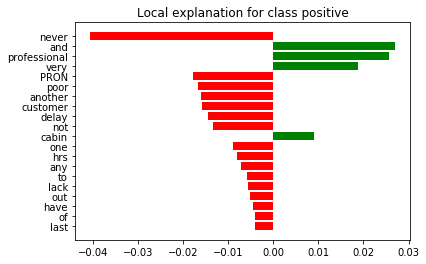

In [40]:
explainer = LimeTextExplainer(class_names=['negative', 'positive'])
explanation = explainer.explain_instance(text_sample, pipeline.predict_proba, num_features=20)
explanation.as_pyplot_figure();
plt.show()

#### Interpretation der Ergebnisse
In der Abbildung ist zu erkennen, dass anscheinend besonders "Professionalität" einen positiven lokalen Einfluss auf die Bewertung hat. Das ist auch daran zu erkennen, dass die Wörter "cabin" und "crew" beide einen positiven lokalen Einfluss haben. Das Wort "very" beeinflusst die Bewertung auch positiv , wohingegen die Wörter "not", "never" und "poor" einen negativen lokalen Einfluss auf die Bewertung haben.

## 3.4 Interpretation strukturierter Daten
Im letzten Schritt werden alle zur Verfügung stehenden Daten zusammengeführt und in einem einzigen Modell letzten Endes verwendet, das dann interpretiert werden soll.
Dazu werden kurz mehrere Modelle betrachtet und evaluiert, um das *beste* dann weiter zu nutzen. Zusätzlich werden einige Features aus dem Text generiert um im Trainingsprozess mit verwendet zu werden.

### Feature Engineering
Das Feature Egineering bezieht sich wie oben bereits erwähnt nur auf die unstrukturierten Daten.

In [41]:
# Feature 1: number of tokens of a tweet
X['no_tokens'] = airline['content'].apply(lambda x: len(x.split()))

In [42]:
# Feature 2: number of characters in a tweet
X['no_chars'] = airline['content'].apply(lambda x: len(x))

In [43]:
# Feature 3: sentiment output generated from the text by the model before
X['pred_sentiment'] = airline['text_prep'].apply(lambda x: pipeline.predict([x]))
X['pred_sentiment'] = X['pred_sentiment'].apply(lambda x: x[0])

In [44]:
X.head()

,cabin_flown,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,value_money_rating,no_tokens,no_chars,pred_sentiment
45,0.666667,4.0,5.0,4.0,2.0,4.0,41,263,1
60,0.000000,4.0,5.0,3.0,2.0,5.0,45,270,1
66,0.000000,5.0,5.0,4.0,3.0,4.0,83,494,1
67,0.000000,4.0,5.0,4.0,0.0,4.0,99,570,1
68,0.000000,4.0,5.0,5.0,3.0,4.0,33,204,1


Weitere Möglichkeiten, die hier jedoch zu keinen Verbesserungen führen würden, wären z.B.
    - Durchschnittliche Länge der Tokens
    - POS der verschiedenen Wortarten
    - etc.

### Modell Auswahl
Die nachfolgenden drei Modelle werden betrachtet:

In [45]:
svr_regr = svm.SVR()
rf_regr = RandomForestRegressor(random_state=0, n_estimators=100)
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
xgb_regr = ensemble.GradientBoostingRegressor(**params)

In [46]:
X_train_regr, X_test_regr, y_train_regr, y_test_regr = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
svr_regr.fit(X_train_regr, y_train_regr)
rf_regr.fit(X_train_regr, y_train_regr)
xgb_regr.fit(X_train_regr, y_train_regr)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Zunächst einmal muss die Performance des Modells betrachtet werden, um sicherzustellen, dass das Modell überhaupt interpretiert werden sollte. Dazu werden folgende Metriken verwendet:
\begin{align}
explained\_variance(y,\hat{y}) & = 1-\frac{Var\{y-\hat{y}\}}{Var\{y\}} \\
MSE(y,\hat{y}) & = \frac{1}{n_{samples}} \sum_{i=0}^{n_{samples}-1} (y_i-\hat{y}_i)^2 \\
R^2(y,\hat{y}) & = 1- \frac{\sum_{i=1}^{n} (y_i-\hat{y}_i)^2}{\sum_{i=1}^{n} (y_i-\bar{y}_i)^2}
\end{align}

In [48]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
y_predicted_svr = svr_regr.predict(X_test_regr)
y_predicted_rf = rf_regr.predict(X_test_regr)
y_predicted_xgb = xgb_regr.predict(X_test_regr)
data = [["SVR",explained_variance_score(y_test_regr, y_predicted_svr),mean_squared_error(y_test_regr, y_predicted_svr),r2_score(y_test_regr, y_predicted_svr)],
        ["RF",explained_variance_score(y_test_regr, y_predicted_rf),mean_squared_error(y_test_regr, y_predicted_rf),r2_score(y_test_regr, y_predicted_rf)],
        ["GB",explained_variance_score(y_test_regr, y_predicted_xgb),mean_squared_error(y_test_regr, y_predicted_xgb),r2_score(y_test_regr, y_predicted_xgb)]]
pd.DataFrame(data,columns=["Classifier","Explained_Variance","Mean_Squared_Error","R2_score"])

,Classifier,Explained_Variance,Mean_Squared_Error,R2_score
0,SVR,0.600076,4.179574,0.596100
1,RF,0.834701,1.711012,0.834654
2,GB,0.855980,1.491080,0.855907


Gradient Boosting Regression war somit in allen drei Kriterien den anderen Algorithmen leicht überlegen. Folglich wird Gradient Boosting Regression weiter verwendet.

In [49]:
idx = 2 # the record we want to explain
numerical_sample = X_train_regr.as_matrix()[idx]

In [50]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_regr.as_matrix(), feature_names=X_train_regr.columns.tolist(),
                                                   class_names=['overall'], verbose=True, mode='regression')

In [51]:
exp = explainer.explain_instance(numerical_sample, xgb_regr.predict, num_features=9)
exp.show_in_notebook(show_table=True)

Intercept 4.9647192571749805
Prediction_local [5.48064083]
Right: 5.5892838017342985


#### Interpretation der Ergebnisse:
Die Abbildung zeigt, dass besonders der Sitzkomfort und das Preis-Leistungs-Verhältnis einen positiven Einfluss auf die Bewertung haben. Auch die Bewertung des Kabinenpersonals und die Klasse haben einen leicht positive Wirkung auf die Review. Ein negativer Zusammenhang ist bei der Verpflegung und bei dem Inflight-Entertainment zu sehen.

In [52]:
explainerXGB = shap.TreeExplainer(xgb_regr)
shap_values_XGB_test = explainerXGB.shap_values(X_test_regr)
shap_values_XGB_train = explainerXGB.shap_values(X_train_regr)

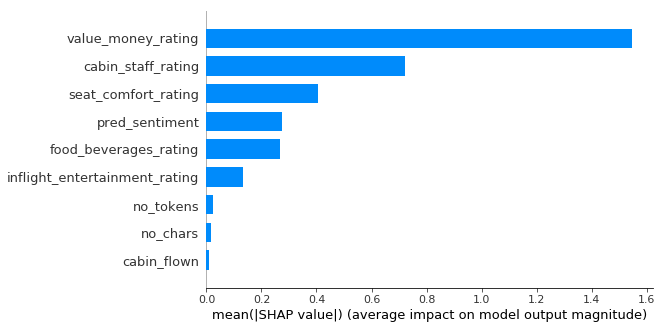

In [53]:
shap.summary_plot(shap_values_XGB_train, X_train_regr, plot_type="bar")

In dieser Abbildung ist wieder zu erkennen, dass besonders das Preis-Leistungs-Verhältnis einen wichtigen Faktor bei der Bewertung spielt. Auch die Bewertung des Kabinenpersonals und der Sitzkomfort spielen wieder eine große Rolle. Auch das Sentiment der Bewertung hat hier einen Einfluss, wenn auch keinen sehr großen. Keinen Einfluss haben die Anzahl der Tokens, die Anzahl der Zeichen und die Beförderungsklasse.

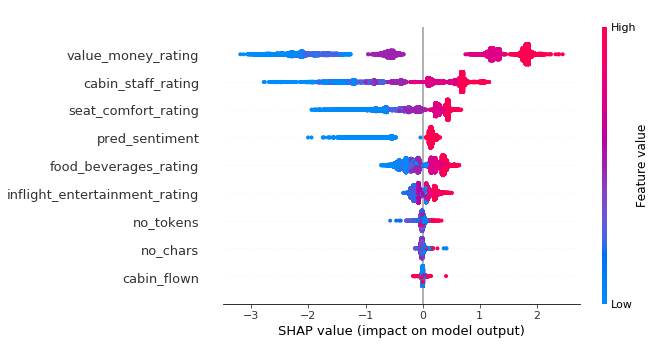

In [54]:
shap.summary_plot(shap_values_XGB_train, X_train_regr)

Es ist zu erkennen, dass das Preis-Leistungs-Verhältnis besonders einen hohen positiven Einfluss hat, wohingegen es zwar einen Einfluss auf die Negativität einer Review hat, jedoch keinen so hohen. Auch das Kabinenpersonal hat sowohl eine negative als auch eine positive Auswirkung auf die Bewerung, allerdings spielt es keine so große Bedeutung, wie das Preis-Leistungs-Verhältnis. Auch hier ist wieder zu sehen, dass die Anzahl der Tokens, die Anzahl der Zeichen und die Beförderungsklasse keinen großen Einfluss haben, sowohl im positiven als auch im negativen.

# 4. Zusammenfassung und Fazit

Diese Arbeit zeigt, welche Einflussfaktoren eine Rolle spielen. Dabei wurde zunächst eine explorative Datenanalyse durchgeführt um sich einen Überblick von dem Datensatz zu verschaffen.

Daraufhin wurden mithilfe von Linearer Regression und Logistischer Regression Zusammenhänge im Datensatz analysiert. Hier wurde herausgefunden, dass besonders das Preis-Leistungs-Verhältnis eine wichtige Rolle bei der Bewertung einer Fluglinie spielt. Dies gilt besonders für Low-Cost Airlines, wo zu erkennen ist, dass zusätzliche Services, wie Essen oder Getränke eher eine untergeordnete Rolle spielen. Anders ist es bei den klassischen Airlines. Hier haben diese Aspkete eine größere Wirkung als bei den Low-Cost Fluglinien. 

Im letzten Teil wurden dann mithilfe der Verfahren LIME und SHAP versucht Machine Learning Verfahren, die sonst als *Black Box Modelle* bekannt sind, zu entschlüssen und interpretierbar zu machen. Hier konnten die Ergebisse aus Teil Zwei bestätigt werden. Weiter konnte hier erkannt werden, wie stark die einzelnen Bewertungskriterien lokal einen Einfluss auf die Bewertungen haben.****

## Literatur
Nguyen, Quang. "Skytrax Reviews Dataset". 2015 Link: https://github.com/quankiquanki/skytrax-reviews-dataset

Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

Hu, Nan, Paul A. Pavlou, and Jie Jennifer Zhang. "Why do online product reviews have a J-shaped distribution? Overcoming biases in online word-of-mouth communication." Communications of the ACM 52.10 (2009): 144-147.

Lundberg, Scott M., and Su-In Lee. "A unified approach to interpreting model predictions." Advances in Neural Information Processing Systems. 2017.

Poduska, Joshua "SHAP and LIME Python Libraries: Part 2 – Using SHAP and LIME". Dominodatalab 2019. Link: https://blog.dominodatalab.com/shap-lime-python-libraries-part-2-using-shap-lime/

Blei, David M., Andrew Y. Ng, and Michael I. Jordan. "Latent dirichlet allocation." Journal of machine Learning research 3.Jan (2003): 993-1022.

Singh, Aditya. "NCSS Statistical Software Ridge Regression". Unknown Date.